In [16]:
import numpy as np

import matplotlib.pyplot as plt

from astropy.io import fits
from astropy import stats
from astropy.modeling.models import Gaussian2D, Lorentz2D, Moffat2D
from astropy.modeling import fitting
import astropy.units as u

from photutils.aperture import CircularAperture

from mmtwfs.wfs import check_wfsdata, wfsfind

In [2]:
%load_ext autoreload
%autoreload 2
#%matplotlib widget

In [3]:
bino_file = "/Volumes/Elements_18TB/wfsdat/20241001/wfs_ff_cal_img_2024.10.01T025918.888.fits"
bino_file = "~/MMT/wfsdat/20250203/wfs_ff_cal_img_2025.02.03T114159.989.fits"
bino_file = "~/MMT/wfsdat/20250203/wfs_ff_cal_img_2025.02.03T123505.342.fits"
data = check_wfsdata(bino_file)

In [4]:
mean, median, stddev = stats.sigma_clipped_stats(data, sigma=3.0, maxiters=None)

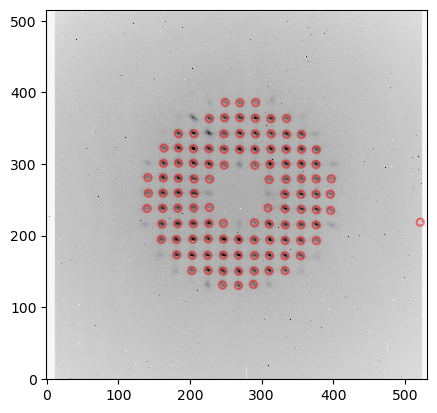

In [5]:
srcs, wfsfind_fig = wfsfind(data, fwhm=6., threshold=4., std=stddev, plot=True)

In [6]:
apers = CircularAperture(
    list(zip(srcs['xcentroid'], srcs['ycentroid'])),
    r=12.
)

In [7]:
masks = apers.to_mask(method='subpixel')
sigma = 0.0
snrs = []
spot = np.zeros(masks[0].shape)
for m in masks:
    subim = m.cutout(data)

    # make co-added spot image for use in calculating the seeing
    if subim.shape == spot.shape:
        spot += subim

    signal = subim.sum()
    noise = np.sqrt(stddev**2 * subim.shape[0] * subim.shape[1])
    snr = signal / noise
    snrs.append(snr)

snrs = np.array(snrs)
fits.writeto("spot.fits", spot, overwrite=True)

back = np.mean([spot[:2, :].mean(), spot[-2:, :].mean(), spot[:, :2].mean(), spot[:, -2:].mean()])
print(back)
spot -= back
g2d = Gaussian2D(amplitude=spot.max(), x_mean=spot.shape[1]/2, y_mean=spot.shape[0]/2)
l2d = Lorentz2D(amplitude=spot.max(), x_0=spot.shape[1]/2, y_0=spot.shape[0]/2)
m2d = Moffat2D(amplitude=spot.max(), x_0=spot.shape[1]/2, y_0=spot.shape[0]/2)

model = m2d
gmodel = g2d
fitter = fitting.DogBoxLSQFitter()
y, x = np.mgrid[:spot.shape[0], :spot.shape[1]]
fit = fitter(model, x, y, spot)
gfit = fitter(gmodel, x, y, spot)

gsigma = 0.5 * (gfit.x_stddev.value + gfit.y_stddev.value)
#print(sigma)
print(fit.fwhm, gsigma * stats.gaussian_sigma_to_fwhm)

311859.01
5.287631784129794 5.974799511281909


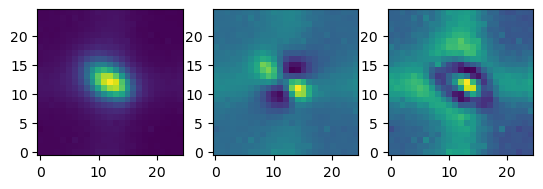

In [8]:
fig, ax = plt.subplots(1, 3)
im1 = ax[0].imshow(spot, origin='lower')
im2 = ax[1].imshow(spot - fit(x, y), origin='lower')
im2 = ax[2].imshow(spot - gfit(x, y), origin='lower')
plt.show()

In [13]:
gfit

<Gaussian2D(amplitude=353096.2220428, x_mean=11.79685004, y_mean=12.14863775, x_stddev=2.07205651, y_stddev=3.00247097, theta=-14.67652708)>

In [116]:
stats.gaussian_fwhm_to_sigma * fit.fwhm

np.float64(2.124444012896353)

In [17]:
(gfit.theta * u.rad).to(u.deg)

<Quantity -840.90305982 deg>